# GNN Decoder Experiments for Regular LDPC Codes

This notebook reproduces the regular LDPC code results in the paper [Graph Neural Networks for Channel Decoding](https://arxiv.org/pdf/2207.14742.pdf).

**Remark**: the training can take several hours. However, pre-trained weights are stored in this repository and can be directly loaded to reproduce the results.

This notebook requires [Sionna](https://nvlabs.github.io/sionna/).

In [1]:
# general imports
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# load required Sionna components
from sionna.fec.utils import load_parity_check_examples, LinearEncoder, gm2pcm
from sionna.utils.plotting import PlotBER
from sionna.fec.ldpc import LDPCBPDecoder

%load_ext autoreload
%autoreload 2
from gnn import * # load GNN functions
from wbp import * # load weighted BP functions

In [2]:
tf.get_logger().setLevel('INFO') # ignore tf warnings related to autograph

gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 2
Only GPU number 0 used.


## Define Hyperparameters and Load Code

We define all parameters as dictionary to support different architectures for different codes.


In [3]:
#----- BCH -----
params={
    # --- Code Parameters ---
        "code": "reg-LDPC",
        "n_des": 100, # target codeword length (code generation may slightly increase n)
        "v": 3, # VN degree
        "c": 6, # VN degree
    # --- GNN Architecture ----
        "num_embed_dims": 16,
        "num_msg_dims": 16,
        "num_hidden_units": 64,
        "num_mlp_layers": 2,
        "num_iter": 10,
        "reduce_op": "mean",
        "activation": "tanh",
        "clip_llr_to": None,
        "use_attributes": False,
        "node_attribute_dims": 0,
        "msg_attribute_dims": 0,
        "return_infobits": False,
        "use_bias": True,        
    # --- Training ---- # 
        "batch_size": [150, 150, 150], # bs, iter, lr must have same dim
        "train_iter": [50000, 200000, 300000],
        "learning_rate": [2e-4, 1e-4, 1e-5],
        "ebno_db_train": [2., 4.],
        "ebno_db_eval": 2.5,          
        "batch_size_eval": 2000, # batch size only used for evaluation during training
        "eval_train_steps": 1000, # evaluate model every N iters
    # --- Log ----
        "save_weights_iter": 10000, # save weights every X iters
        "run_name": "LDPC_reg_01", # name of the stored weights/logs
        "save_dir": "results/", # folder to store results
    # --- MC Simulation parameters ----
        "eval_dec_iter": 20, # number of decoding iters to evaluate
        "mc_iters": 1000,
        "mc_batch_size": 2000,
        "num_target_block_errors": 1000,
        "ebno_db_min": 0.,
        "ebno_db_max": 4.,
        "ebno_db_stepsize": 0.25,
        "eval_ns": [100, 500, 1000],        
    # --- Weighted BP parameters ----
        "simulate_wbp": True, # simulate weighted BP as baseline
        "wbp_batch_size" : [1000, 1000, 1000],
        "wbp_train_iter" : [300, 2000, 2000],
        "wbp_learning_rate" : [1e-2, 1e-3, 1e-3],
        "wbp_ebno_train" : [2.5, 3., 3.5],
        "wbp_ebno_val" : 5., # validation SNR during training
        "wbp_batch_size_val" : 2000,
        "wbp_clip_value_grad" : 10, 
}

## Load / Generate the Graph

In [4]:
# code construction; this will be integrated in Sionna in one of the next releases
def generate_reg_ldpc(v, c, n, allow_flex_len=True, verbose=True):
    """Generate random regular (v,c) LDPC code.

    This functions generates a random LDPC parity-check matrix of length ``n``
    where each variable node (VN) has degree ``v`` and each check node (CN) has
    degree ``c``. Please note that the LDPC code is not optimized to avoid
    short cycles. For encoding, the :class:`~sionna.fec.utils.LinearEncoder`
    layer can be used.

    Input
    -----
    v : int
        Desired variable node (VN) degree.

    c : int
        Desired check node (CN) degree.

    n : int
        Desired codeword length.

    allow_flex_len: bool
        Defaults to True. If True, the resulting codeword length can be
        (slightly) increased.

    verbose : bool
        Defaults to True. If True, code parameters are printed.

    Output
    ------
    (pcm, k, n, coderate):
        Tuple:

    pcm: ndarray
        NumPy array of shape `[n-k, n]` containing the parity-check matrix.

    k: int
        Number of information bits per codeword.

    n: int
        Number of codewords bits.

    coderate: float
        Coderate of the code.


    Note
    ----
    This algorithm only works for regular node degrees. For state-of-the-art
    bit-error-rate performance, usually one needs to optimize irregular LDPC
    codes.
    """

    # check input values for consistency
    assert isinstance(allow_flex_len, bool), \
                                    'allow_flex_len must be bool.'

    # allow slight change in n to keep num edges
    # from CN and VN perspective an integer
    if allow_flex_len:
        for n_mod in range(n, n+2*c):
            if np.mod((v/c) * n_mod, 1.)==0:
                n = n_mod
                if verbose:
                    print("Changing n to: ", n)
                break

    # calculate number of nodes
    coderate = 1 - (v/c) # to be checked
    n_v = n
    n_c = int((v/c) * n)
    k = n_v - n_c

    # generate sockets
    v_socks = np.tile(np.arange(n_v),v)
    c_socks = np.tile(np.arange(n_c),c)
    if verbose:
        print("Number of edges (VN perspective): ", len(v_socks))
        print("Number of edges (CN perspective): ", len(c_socks))
    assert len(v_socks) == len(c_socks), "Number of edges from VN and CN " \
        "perspective does not match. Consider to (slightly) change n."

    # apply random permutations
    np.random.shuffle(v_socks)
    np.random.shuffle(c_socks)

    # and generate matrix
    pcm = np.zeros([n_c, n_v])

    idx = 0
    shuffle_max = 1000 # stop if no success
    shuffle_counter = 0
    cont = True
    while cont:
        # if edge is available, take it
        if pcm[c_socks[idx],v_socks[idx]]==0:
            pcm[c_socks[idx],v_socks[idx]] = 1
            idx += 1 # and go to next socket
            shuffle_counter = 0 # reset counter
            if idx==len(v_socks):
                cont=False
        else: # shuffle sockets
            shuffle_counter += 1
            if shuffle_counter<shuffle_max:
                np.random.shuffle(v_socks[idx:])
                np.random.shuffle(c_socks[idx:])
            else:
                print("Stopping - no solution found!")
                cont=False

    v_deg = np.sum(pcm, axis=0)
    c_deg = np.sum(pcm, axis=1)

    assert((v_deg==v).all()), "VN degree not always v."
    assert((c_deg==c).all()), "CN degree not always c."

    if verbose:
        print(f"Generated regular ({v},{c}) LDPC code of length n={n}")
        print(f"Code rate is r={coderate}.")
        plt.spy(pcm)

    return pcm, k, n, coderate

Loading LDPC code
Changing n to:  100
Number of edges (VN perspective):  300
Number of edges (CN perspective):  300
Generated regular (3,6) LDPC code of length n=100
Code rate is r=0.5.


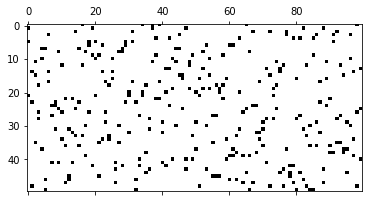

In [5]:
# all codes must provide an encoder-layer and a pcm
if params["code"]=="reg-LDPC":    
    print("Loading LDPC code")
    pcm, k, n, coderate = generate_reg_ldpc(v=params["v"], 
                                            c=params["c"],  
                                            n=params["n_des"], 
                                            allow_flex_len=True, 
                                            verbose=True)

    encoder = LinearEncoder(pcm, is_pcm=True)
    params["k"] = k
    params["n"] = n
else:
    raise ValueError("Unknown code type")

## Simulate Baseline BER Performance

In [6]:
ber_plot = PlotBER(f"GNN-based Decoding - {params['code']}, (k,n)=({k},{n})")
ebno_dbs = np.arange(params["ebno_db_min"],
                     params["ebno_db_max"]+1,
                     params["ebno_db_stepsize"])

In [7]:
# uncoded QPSK
e2e_uncoded = E2EModel(None, None, k=100, n=100) # k and n are not relevant here
ber_plot.simulate(e2e_uncoded,
                  ebno_dbs=ebno_dbs,
                  batch_size=params["mc_batch_size"],
                  num_target_block_errors=params["num_target_block_errors"],
                  legend="Uncoded",
                  soft_estimates=True,
                  max_mc_iter=params["mc_iters"],
                  forward_keyboard_interrupt=False,
                  show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 7.9590e-02 | 1.0000e+00 |       15918 |      200000 |         2000 |        2000 |         1.7 |reached target block errors
     0.25 | 7.2575e-02 | 9.9950e-01 |       14515 |      200000 |         1999 |        2000 |         0.0 |reached target block errors
      0.5 | 6.6960e-02 | 9.9900e-01 |       13392 |      200000 |         1998 |        2000 |         0.0 |reached target block errors
     0.75 | 6.0840e-02 | 9.9750e-01 |       12168 |      200000 |         1995 |        2000 |         0.0 |reached target block errors
      1.0 | 5.6340e-02 | 9.9650e-01 |       11268 |      200000 |         1993 |        2000 |         0.0 |reached target block errors
     1.25 | 5.0950e-02 | 9.9600e-01 |       10190 |      200000 |

In [ ]:
# train and simulate Weighted BP as additional baseline
# please note that the training parameters could be critical 
if params["simulate_wbp"]:
    evaluate_wbp(params, pcm, encoder, ebno_dbs, ber_plot)

Iter: 0 loss: 0.003037 ber: 0.0001 bmi: 0.999
Iter: 50 loss: 0.002917 ber: 0.0000 bmi: 1.000
Iter: 100 loss: 0.002769 ber: 0.0000 bmi: 1.000
Iter: 150 loss: 0.002290 ber: 0.0000 bmi: 1.000
Iter: 200 loss: 0.002667 ber: 0.0001 bmi: 1.000
Iter: 250 loss: 0.002765 ber: 0.0001 bmi: 0.999
Iter: 0 loss: 0.002426 ber: 0.0000 bmi: 1.000
Iter: 50 loss: 0.002623 ber: 0.0000 bmi: 1.000
Iter: 100 loss: 0.002768 ber: 0.0001 bmi: 1.000
Iter: 150 loss: 0.002689 ber: 0.0000 bmi: 1.000
Iter: 200 loss: 0.002897 ber: 0.0001 bmi: 0.999
Iter: 250 loss: 0.002492 ber: 0.0000 bmi: 1.000
Iter: 300 loss: 0.002486 ber: 0.0000 bmi: 1.000
Iter: 350 loss: 0.002876 ber: 0.0000 bmi: 1.000
Iter: 400 loss: 0.002809 ber: 0.0000 bmi: 1.000
Iter: 450 loss: 0.002554 ber: 0.0000 bmi: 1.000
Iter: 500 loss: 0.003199 ber: 0.0001 bmi: 0.999
Iter: 550 loss: 0.002936 ber: 0.0001 bmi: 0.999
Iter: 600 loss: 0.002664 ber: 0.0000 bmi: 1.000
Iter: 650 loss: 0.002330 ber: 0.0000 bmi: 1.000
Iter: 700 loss: 0.003071 ber: 0.0001 bmi: 0.99

### GNN-based Decoding


In [ ]:
tf.random.set_seed(2) # we fix the seed to ensure stable convergence 

# init the GNN decoder
gnn_decoder = GNN_BP(pcm=pcm,
                     num_embed_dims=params["num_embed_dims"],
                     num_msg_dims=params["num_msg_dims"],
                     num_hidden_units=params["num_hidden_units"],
                     num_mlp_layers=params["num_mlp_layers"],
                     num_iter=params["num_iter"],
                     reduce_op=params["reduce_op"],
                     activation=params["activation"],
                     output_all_iter=True,
                     clip_llr_to=params["clip_llr_to"],
                     use_attributes=params["use_attributes"],
                     node_attribute_dims=params["node_attribute_dims"],
                     msg_attribute_dims=params["msg_attribute_dims"],
                     use_bias=params["use_bias"])
                     
e2e_gnn = E2EModel(encoder, gnn_decoder, k, n)

In [ ]:
# init model and print summary
e2e_gnn(1, 1.)
e2e_gnn.summary()

and let's train the model...

In [ ]:
train = False # remark: training takes several hours
if train:
    train_gnn(e2e_gnn, params)
else:
    # you can also load the precomputed weights
    load_weights(e2e_gnn, "weights/LDPC_reg_precomputed.npy")

## Evaluate Final Performance

We now evaluate the performance for different codeword lengths.

In [ ]:
for n_eval in params["eval_ns"]:
    # generate new code for each length
    pcm, k, n, coderate = generate_reg_ldpc(v=params["v"], 
                                            c=params["c"],  
                                            n=n_eval, 
                                            allow_flex_len=True, 
                                            verbose=False)

    encoder = LinearEncoder(pcm, is_pcm=True)

    # simulate "conventional" BP performance first
    bp_decoder = LDPCBPDecoder(pcm,
                               num_iter=params["eval_dec_iter"],
                               hard_out=False)
    e2e_bp = E2EModel(encoder, bp_decoder, k, n)
    ber_plot.simulate(e2e_bp,
                      ebno_dbs=ebno_dbs,
                      batch_size=params["mc_batch_size"],
                      num_target_block_errors=params["num_target_block_errors"],
                      legend=f"BP-{bp_decoder._num_iter.numpy()} n={n}",
                      soft_estimates=True,
                      max_mc_iter=params["mc_iters"],
                      forward_keyboard_interrupt=False,
                      show_fig=False);

    # instantiate new decoder for each number of iter (otherwise no retracing)
    gnn_dec_temp = GNN_BP(pcm=pcm,
                          num_embed_dims=params["num_embed_dims"],
                          num_msg_dims=params["num_msg_dims"],
                          num_hidden_units=params["num_hidden_units"],
                          num_mlp_layers=params["num_mlp_layers"],
                          num_iter=params["eval_dec_iter"],
                          reduce_op=params["reduce_op"],
                          activation=params["activation"],
                          output_all_iter=False,
                          clip_llr_to=params["clip_llr_to"],
                          use_attributes=params["use_attributes"],
                          node_attribute_dims=params["node_attribute_dims"],
                          msg_attribute_dims=params["msg_attribute_dims"],
                          use_bias=params["use_bias"])    
    # generate new model   
    model = E2EModel(encoder, gnn_dec_temp, k, n)
    model(1,1.) # init model
    # copy weights from trained decoder
    model._decoder.set_weights(gnn_decoder.get_weights())

    # and run the BER simulations
    ber_plot.simulate(model,
                     ebno_dbs=ebno_dbs,
                     batch_size=params["mc_batch_size"],
                     num_target_block_errors=500,
                     legend=f"GNN-{params['eval_dec_iter']} n={n}",
                     soft_estimates=True,
                     max_mc_iter=params["mc_iters"],
                     forward_keyboard_interrupt=False,
                     show_fig=False);

## Add GNN BCH Decoder

In [18]:
# define BCH architecture
params_bch={
    # --- Code Parameters ---
        "code": "BCH", # (63,45)
    # --- GNN Architecture ----
        "num_embed_dims": 20,
        "num_msg_dims": 20,
        "num_hidden_units": 40,
        "num_mlp_layers": 2,
        "num_iter": 8,
        "reduce_op": "mean",
        "activation": "tanh",
        "clip_llr_to": 20.,
        "use_attributes": False,
        "node_attribute_dims": 0,
        "msg_attribute_dims": 0,
        "use_bias": False,
}

pcm, k, n, coderate = generate_reg_ldpc(v=params["v"], 
                                            c=params["c"],  
                                            n=100, # we only evaluate for n=100
                                            allow_flex_len=True, 
                                            verbose=False)

encoder = LinearEncoder(pcm, is_pcm=True)

gnn_dec_eval = GNN_BP(pcm=pcm,
                      num_embed_dims=params_bch["num_embed_dims"],
                      num_msg_dims=params_bch["num_msg_dims"],
                      num_hidden_units=params_bch["num_hidden_units"],
                      num_mlp_layers=params_bch["num_mlp_layers"],
                      num_iter=params["eval_dec_iter"],
                      reduce_op=params_bch["reduce_op"],
                      activation=params_bch["activation"],
                      output_all_iter=False,
                      clip_llr_to=params_bch["clip_llr_to"],
                      use_attributes=params_bch["use_attributes"],
                      node_attribute_dims=params_bch["node_attribute_dims"],
                      msg_attribute_dims=params_bch["msg_attribute_dims"],
                      use_bias=params_bch["use_bias"])    

# generate new model   
model = E2EModel(encoder, gnn_dec_eval, k, n)
model(1,1.) # init model
# copy weights from trained decoder
load_weights(model, "weights/BCH_precomputed.npy")

# and run the BER simulations
ber_plot.simulate(model,
                  ebno_dbs=ebno_dbs,
                  batch_size=params["mc_batch_size"],
                  num_target_block_errors=500,
                  legend=f"GNN-{params['eval_dec_iter']} n={n}; BCH weights",
                  soft_estimates=True,
                  max_mc_iter=params["mc_iters"],
                  forward_keyboard_interrupt=False,
                  show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.9010e-01 | 1.0000e+00 |       38020 |      200000 |         2000 |        2000 |        13.8 |reached target block errors
     0.25 | 1.8003e-01 | 1.0000e+00 |       36006 |      200000 |         2000 |        2000 |         0.1 |reached target block errors
      0.5 | 1.7280e-01 | 1.0000e+00 |       34561 |      200000 |         2000 |        2000 |         0.1 |reached target block errors
     0.75 | 1.6429e-01 | 1.0000e+00 |       32858 |      200000 |         2000 |        2000 |         0.1 |reached target block errors
      1.0 | 1.5651e-01 | 1.0000e+00 |       31302 |      200000 |         2000 |        2000 |         0.1 |reached target block errors
     1.25 | 1.4577e-01 | 1.0000e+00 |       29153 |      200000 |

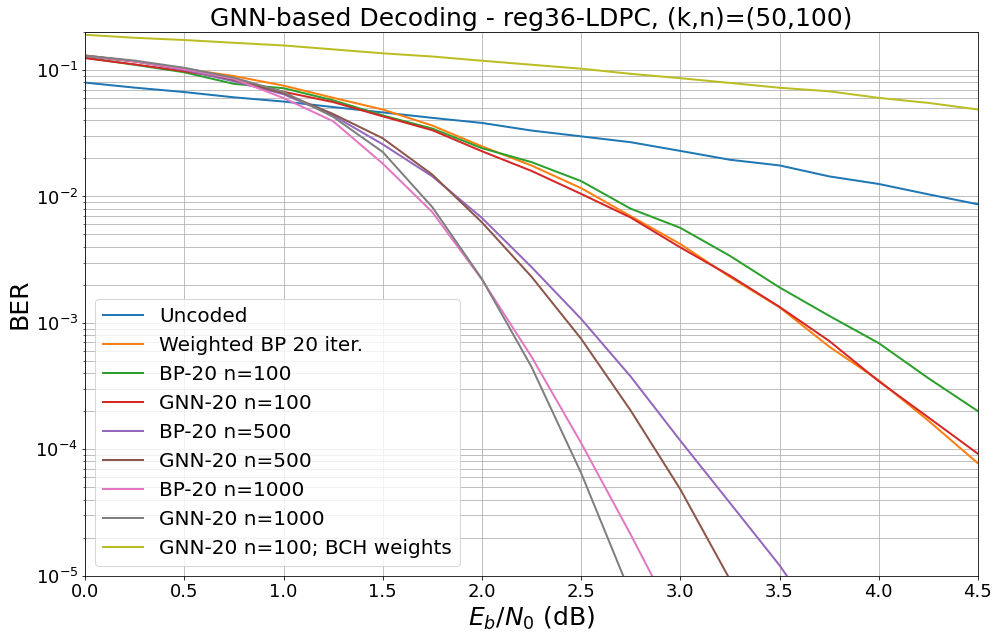

In [19]:
ber_plot(xlim=[0, 4.5], ylim=[1e-5, 0.2]) # show final figure

*Remark*: as we use a non-optimized random LDPC code construction, the resulting LDPC code has a significant error-floor.
This is an artefact of the code construction method and not a related to the decoder itself.

In [20]:
# save results for pgf plots
col_names = ["uncoded"]
if params["simulate_wbp"]:
    col_names.append("wbp-20")
for n in params["eval_ns"]:
    col_names.append("bp_n" + str(n))
    col_names.append("gnn_n" + str(n))
col_names.append("gnn_n100_bch")
export_pgf(ber_plot, col_names)

snr, 	uncoded, 	wbp-20, 	bp_n100, 	gnn_n100, 	bp_n500, 	gnn_n500, 	bp_n1000, 	gnn_n1000, 	gnn_n100_bch, 	
0.000,	7.959000E-02,	1.305650E-01,	1.253900E-01,	1.241400E-01,	1.293100E-01,	1.295820E-01,	1.297725E-01,	1.302065E-01,	1.901000E-01,	
0.250,	7.257500E-02,	1.173950E-01,	1.100850E-01,	1.108750E-01,	1.171340E-01,	1.167670E-01,	1.169960E-01,	1.187355E-01,	1.800300E-01,	
0.500,	6.696000E-02,	1.023250E-01,	9.600000E-02,	9.782000E-02,	1.003250E-01,	1.027090E-01,	1.016290E-01,	1.041950E-01,	1.728050E-01,	
0.750,	6.084000E-02,	8.967000E-02,	7.773000E-02,	8.462500E-02,	8.144300E-02,	8.358300E-02,	8.525500E-02,	8.699850E-02,	1.642900E-01,	
1.000,	5.634000E-02,	7.527000E-02,	7.184000E-02,	6.730500E-02,	6.439500E-02,	6.555700E-02,	6.006900E-02,	6.715150E-02,	1.565100E-01,	
1.250,	5.095000E-02,	6.033500E-02,	5.762000E-02,	5.579000E-02,	4.378700E-02,	4.490400E-02,	3.934700E-02,	4.264200E-02,	1.457650E-01,	
1.500,	4.623000E-02,	4.872500E-02,	4.374500E-02,	4.304000E-02,	2.583800E-02,	2.886300E-02,